<a href="https://colab.research.google.com/github/MasahiroAraki/MLCourse/blob/master/Python/14_semi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第14章 半教師あり学習

## 例題14.3

scikit-learnのLabelPropagationでirisデータの半教師あり学習を行います。

ライブラリの読み込み

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.semi_supervised import LabelPropagation

irisデータの読み込み

In [2]:
iris = load_iris()
X = iris.data
y = iris.target

### 半教師ありデータの作成

まず、どのデータの教師信号を消すかを決めます。
[np.random.choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html)を使って、データのインデックスを表すndarrayから、指定された個数（全体の7割）のインデックスを、重複なしで抜き出します。

In [3]:
unlabeled_points = np.random.choice(np.arange(y.size), int((y.size)*.7), replace=False)
unlabeled_points

array([ 36,  84, 123,  39,  89,  85, 100,  43,  29,  32, 143,  96,  35,
        28, 139, 112,  11,  92,  72, 108,  27,  94,  47,  70,  77, 132,
        18, 145, 125,   5,  16, 141,  91,  24,  52,   4,  93, 110,  74,
       119, 127, 118,  40,  50,  19,  87,  64, 115,  76,  54,  22,  75,
       137, 107,  31, 147,  41,   0, 128, 113, 138,  21, 116,  71,  81,
       144, 117,  68, 148,  65,  61,  23, 140,   3,  44,  25,  98, 126,
         2,  56, 106, 131, 122, 136, 111,  86,  57,  10, 102,  55,  37,
       133,  34,  20,  58, 120,  67, 101,  14,  66,  51,  60, 146,  88,
       114])

教師ベクトルyを[np.copy](https://docs.scipy.org/doc/numpy/reference/generated/numpy.copy.html)を使って変数labelsにコピーし（代入文でコピーするとオブジェクトが共有され、labelsを変更するとyも変わってしまいます）、先ほど抜き出したインデックスに対応する値を-1に書き換えます。

In [4]:
labels = np.copy(y)
labels[unlabeled_points] = -1
labels

array([-1,  0, -1, -1, -1, -1,  0,  0,  0,  0, -1, -1,  0,  0, -1,  0, -1,
        0, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1,  0, -1, -1,  0,
       -1, -1, -1, -1,  0, -1, -1, -1,  0, -1, -1,  0,  0, -1,  0,  0, -1,
       -1, -1,  1, -1, -1, -1, -1, -1,  1, -1, -1,  1,  1, -1, -1, -1, -1,
       -1,  1, -1, -1, -1,  1, -1, -1, -1, -1,  1,  1,  1, -1,  1,  1, -1,
       -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,  1, -1,  1, -1,  1, -1, -1,
       -1,  2,  2,  2, -1, -1, -1,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  2, -1, -1,  2, -1, -1, -1, -1,  2,  2, -1, -1, -1,  2,  2,
       -1, -1, -1, -1, -1, -1,  2, -1, -1, -1, -1, -1, -1,  2])

これを教師ベクトルとして、[LabelPropagation](http://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html)で半教師あり学習を行います。

In [5]:
lp = LabelPropagation(max_iter=10000)
lp.fit(X, labels)

LabelPropagation(gamma=20, kernel='rbf', max_iter=10000, n_jobs=None,
                 n_neighbors=7, tol=0.001)

正解なしデータの割り当て結果を表示します。

In [6]:
lp.score(X[unlabeled_points], y[unlabeled_points])

0.9523809523809523

正解付きデータを5%, 10%, 20%, 30%と変えて、それぞれ100回ずつ学習を試みて性能を評価します。

In [7]:
labeled_percent = [0.05, 0.1, 0.2, 0.3]
num = y.size
for labeled in labeled_percent :
    score = 0
    for i in range(100):
        unlabeled_points = np.random.choice(np.arange(num),int(num-num*labeled), replace=False)
        labels = np.copy(y)
        labels[unlabeled_points] = -1
        lp.fit(X, labels)
        score += lp.score(X[unlabeled_points], y[unlabeled_points])
    print("{0}{1:4.1f}{2}{3:6.3f}".format("labeled:", labeled*100, "%, score=", score/100))        

/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:288: ConvergenceWarning: max_iter=10000 was reached without convergence.
  category=ConvergenceWarning


labeled: 5.0%, score= 0.839
labeled:10.0%, score= 0.914
labeled:20.0%, score= 0.953
labeled:30.0%, score= 0.955


## データ拡張

画像データ (CIFER10) の拡張を行って、性能の変化を観察します。

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
cf10 = keras.datasets.cifar10
(X_train,y_train),(X_test,y_test)=keras.datasets.cifar10.load_data()

データ拡張を行う関数（Keras.Sequentialのインスタンス）を定義します。

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.07),
        layers.experimental.preprocessing.RandomZoom(0.08),
    ]
)

データ拡張結果を確認します。

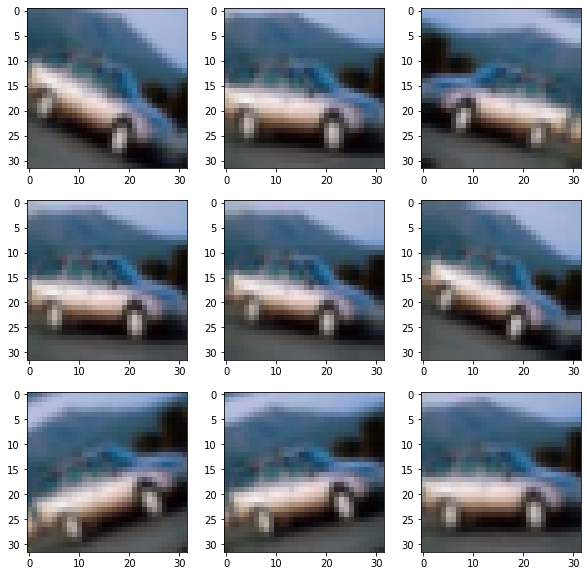

In [11]:
fig_num = 4
plt.figure(figsize=(10,10))
for i in range(9):
    im = data_augmentation(np.expand_dims(X_train[fig_num], axis=0))
    plt.subplot(3, 3, i+1)
    plt.imshow(im[0])
plt.show()

In [12]:
X_train = X_train / 255.0
X_test = X_test / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

9章の課題で、正解率67.14%のモデルに対してデータ拡張を行います。入力データが変動しているので、ドロップアウトは除外しておきます。

In [13]:
model3 = keras.Sequential([
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    #layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])
model3.build(input_shape=(None, 32, 32, 3))
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 6, 32)          128       
_________________________________________________________________
flatten (Flatten)            (None, 1152)             

In [14]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

損失(loss)の減り具合などを見ながら、繰り返し回数(epochs)を調整します。

In [15]:
model3.fit(X_train, y_train, epochs=15, batch_size=128)

Epoch 1/15
391/391 [==============================] - 5s 5ms/step - loss: 1.6231 - accuracy: 0.4152
Epoch 2/15
391/391 [==============================] - 2s 5ms/step - loss: 1.2108 - accuracy: 0.5723
Epoch 3/15
391/391 [==============================] - 2s 5ms/step - loss: 1.0916 - accuracy: 0.6159
Epoch 4/15
391/391 [==============================] - 2s 4ms/step - loss: 1.0098 - accuracy: 0.6431
Epoch 5/15
391/391 [==============================] - 2s 5ms/step - loss: 0.9651 - accuracy: 0.6630
Epoch 6/15
391/391 [==============================] - 2s 4ms/step - loss: 0.9174 - accuracy: 0.6765
Epoch 7/15
391/391 [==============================] - 2s 4ms/step - loss: 0.8959 - accuracy: 0.6879
Epoch 8/15
391/391 [==============================] - 2s 4ms/step - loss: 0.8715 - accuracy: 0.6972
Epoch 9/15
391/391 [==============================] - 2s 4ms/step - loss: 0.8421 - accuracy: 0.7063
Epoch 10/15
391/391 [==============================] - 2s 4ms/step - loss: 0.8197 - accuracy: 0.7151

In [16]:
test_loss, test_acc = model3.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 1.0180 - accuracy: 0.6778
Test accuracy: 0.6777999997138977


## 課題1

例題14.3の手順で、使用するデータをbreast_cancerに変更して半教師あり学習を行ってください。その際、以下の点に注意してください。

* 学習時にエラーが出てしまう場合は、irisデータとbreast_cancerデータの両方のデータを見て、何が違うかを考えてみてください。
* 低い性能しか出ないときは、LabelPropagationのハイパーパラメータ調整を試みてください。


## 課題2

CNNを用いたCIFER10の識別において、データ拡張のパラメータや方法を変更して性能評価をしてください。